In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

In [2]:
df = pd.read_csv(r'D:\Mtech Project\Code Files\Report_Generation\generated_synthetic_data.csv')

In [3]:
df.head()

,ENGINE_RPM,ENGINE_COOLANT_TEMP,ENGINE_LOAD,THROTTLE_POS,INTAKE_MANIFOLD_PRESSURE,AIR_INTAKE_TEMP,ENGINE_POWER,TIMING_ADVANCE,TROUBLE_CODES,MODEL
0,-0.483289,1.819693,2.264298,0.307681,18.971967,-0.891699,-5.337629,1.663023,6,0
1,1.792010,0.127700,0.418440,1.004883,-0.521098,-0.897051,-5.337282,-0.838474,9,0
2,2.170687,1.471967,0.722376,0.786698,-6.337609,-1.668890,-5.337825,-1.060420,4,0
3,1.720239,1.995335,0.230258,5.347556,-4.822878,1.000610,-5.340326,-1.560652,8,0
4,1.542721,1.929527,1.368151,1.718805,-1.941518,-0.961434,-5.337438,0.322018,6,0


In [4]:
df.columns

Index(['ENGINE_RPM', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'THROTTLE_POS',
       'INTAKE_MANIFOLD_PRESSURE', 'AIR_INTAKE_TEMP', 'ENGINE_POWER',
       'TIMING_ADVANCE', 'TROUBLE_CODES', 'MODEL'],
      dtype='object')

In [5]:
df.describe()

,ENGINE_RPM,ENGINE_COOLANT_TEMP,ENGINE_LOAD,THROTTLE_POS,INTAKE_MANIFOLD_PRESSURE,AIR_INTAKE_TEMP,ENGINE_POWER,TIMING_ADVANCE,TROUBLE_CODES,MODEL
count,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000,35742.000000
mean,0.238887,0.861566,0.607251,0.781156,0.192846,-0.420412,-3.523199,-0.122949,4.281182,0.498321
std,1.246801,1.084553,1.326272,1.038919,2.824349,0.905043,2.595409,0.962978,2.795453,0.767863
min,-2.905266,-4.837296,-8.326769,-1.823951,-35.800572,-2.778244,-5.342043,-3.337648,0.000000,0.000000
25%,-0.844772,0.247400,-0.266327,0.204230,-0.300554,-1.115394,-5.338911,-0.758044,2.000000,0.000000
50%,0.112901,1.258965,0.428484,0.773355,-0.040288,-0.567387,-5.337739,-0.175465,5.000000,0.000000
75%,1.173753,1.626372,1.306662,1.335661,0.339458,0.219078,0.187317,0.548840,7.000000,1.000000
max,4.164243,4.597279,17.332665,10.533853,71.512436,2.926139,0.187317,2.822506,9.000000,2.000000


In [27]:
in_st = df.describe()
means_array = in_st.loc['mean'].values
print(means_array)

[ 0.23888651  0.86156558  0.60725061  0.7811556   0.19284566 -0.42041162
 -3.52319855 -0.12294865  4.2811818   0.4983213 ]


In [28]:
std_array = in_st.loc['std'].values
print(std_array)

[1.24680145 1.08455267 1.326272   1.03891892 2.8243492  0.90504288
 2.59540894 0.96297799 2.79545312 0.76786337]


In [6]:
df.shape

(35742, 10)

Model: {'citroen': 0, 'peugeot': 1, 'volkswagen': 2}

In [7]:
MODEL_counts = print(df.groupby('MODEL')['MODEL'].count())

MODEL
0    24000
1     5673
2     6069
Name: MODEL, dtype: int64


{'B0004': 0, 'C0300': 1, 'C1004': 2, 'P0078': 3, 'P0079': 4, 'P0133': 5, 'P2004': 6, 'P2036': 7, 'P3000': 8, 'U1004': 9}

In [8]:
TROUBLE_CODE_counts = print(df.groupby('TROUBLE_CODES')['TROUBLE_CODES'].count())

TROUBLE_CODES
0    3000
1    5673
2    3000
3    3000
4    3000
5    6069
6    3000
7    3000
8    3000
9    3000
Name: TROUBLE_CODES, dtype: int64


In [9]:
X = df.drop(columns=['TROUBLE_CODES', 'MODEL'])
y = df['TROUBLE_CODES']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (25019, 8)
X_test shape: (10723, 8)
y_train shape: (25019,)
y_test shape: (10723,)


In [11]:
from xgboost import XGBClassifier

In [12]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
params = {
    'objective': 'multi:softmax',  # For multiclass classification
    'num_class': len(np.unique(y_train)),  # Number of classes
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'merror'
}

In [14]:
xgb_model = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=20)

[0]	train-merror:0.21148	test-merror:0.23370
[1]	train-merror:0.19297	test-merror:0.21832
[2]	train-merror:0.18398	test-merror:0.20890
[3]	train-merror:0.17603	test-merror:0.20461
[4]	train-merror:0.17095	test-merror:0.20050
[5]	train-merror:0.16595	test-merror:0.19789
[6]	train-merror:0.16044	test-merror:0.19612
[7]	train-merror:0.15680	test-merror:0.19323
[8]	train-merror:0.15340	test-merror:0.18922
[9]	train-merror:0.15029	test-merror:0.18614
[10]	train-merror:0.14665	test-merror:0.18586
[11]	train-merror:0.14353	test-merror:0.18372
[12]	train-merror:0.14113	test-merror:0.18288
[13]	train-merror:0.13829	test-merror:0.18055
[14]	train-merror:0.13454	test-merror:0.17952
[15]	train-merror:0.13210	test-merror:0.17803
[16]	train-merror:0.12910	test-merror:0.17663
[17]	train-merror:0.12714	test-merror:0.17551
[18]	train-merror:0.12387	test-merror:0.17420
[19]	train-merror:0.12107	test-merror:0.17346
[20]	train-merror:0.11895	test-merror:0.17309
[21]	train-merror:0.11699	test-merror:0.1714

In [15]:
# Predict on the training set
y_train_pred = xgb_model.predict(dtrain)

# Print train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.9305727646988289


In [16]:
y_pred = xgb_model.predict(dtest)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8340949361186235


In [18]:
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       919
           1       0.98      0.99      0.99      1725
           2       0.74      0.75      0.75       914
           3       0.67      0.71      0.69       839
           4       0.75      0.68      0.72       905
           5       0.99      0.99      0.99      1802
           6       0.70      0.69      0.69       898
           7       0.80      0.85      0.83       912
           8       0.82      0.76      0.79       900
           9       0.69      0.70      0.69       909

    accuracy                           0.83     10723
   macro avg       0.80      0.80      0.80     10723
weighted avg       0.83      0.83      0.83     10723



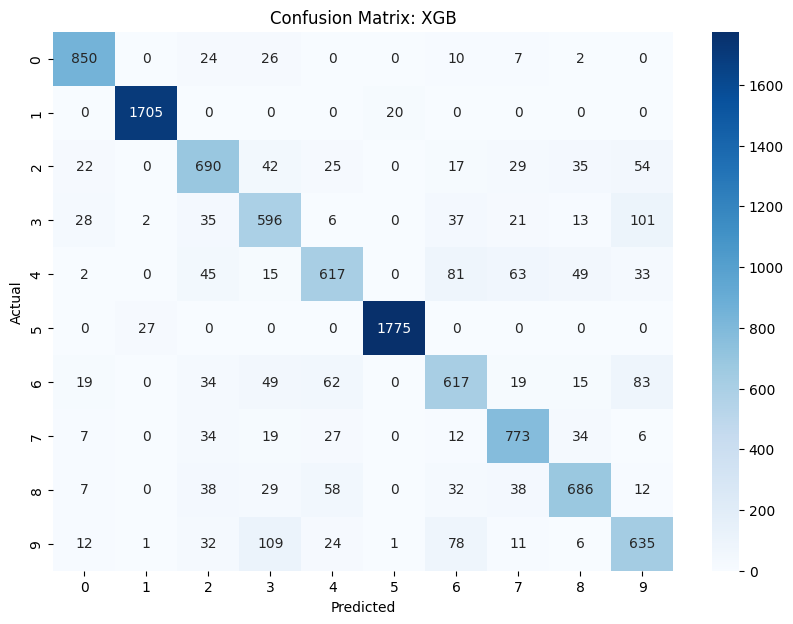

In [19]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGB')
plt.show()


In [62]:
joblib.dump(xgb_model, 'D:\Mtech Project\Code Files\Report_Generation\classification_model.pkl')

['D:\\Mtech Project\\Code Files\\Report_Generation\\classification_model.pkl']

Live Testing

In [33]:
feature_names = [
    "ENGINE_RPM", "ENGINE_COOLANT_TEMP", "ENGINE_LOAD", "THROTTLE_POS",
    "INTAKE_MANIFOLD_PRESSURE", "AIR_INTAKE_TEMP", "ENGINE_POWER", "TIMING_ADVANCE"
]

In [38]:
label_to_dtc = {
    0: 'B0004', 1: 'C0300', 2: 'C1004', 3: 'P0078', 4: 'P0079',
    5: 'P0133', 6: 'P2004', 7: 'P2036', 8: 'P3000', 9: 'U1004'
}

In [34]:
def scale_engine_parameters(input_values):
    means_array = np.array([0.23888651, 0.86156558, 0.60725061, 0.7811556, 0.19284566, -0.42041162, -3.52319855, -0.12294865])
    std_array = np.array([1.24680145, 1.08455267, 1.326272, 1.03891892, 2.8243492, 0.90504288, 2.59540894, 0.96297799])
    
    input_values = np.array(input_values)
    scaled_values = (input_values - means_array) / std_array
    
    return scaled_values

In [46]:
def get_prediction(xgb_model, input_values):
    scaled_values = scale_engine_parameters(input_values)
    scaled_values = scaled_values.reshape(1, -1)  # Reshape for model input
    dmatrix_input = xgb.DMatrix(scaled_values, feature_names=feature_names)  # Set feature names
    prediction_label = int(xgb_model.predict(dmatrix_input)[0])  # Convert to integer class label
    dtc_code = label_to_dtc.get(prediction_label, "Unknown")  # Get corresponding DTC code
    return prediction_label, dtc_code

In [49]:
input_values = [1659,42,0.063,0.043,24,30,1.6,0.714] 
prediction_label, dtc_code = get_prediction(xgb_model, input_values)
print(prediction_label)
print("Predicted DTC is : ",dtc_code)


5
Predicted DTC is :  P0133
